In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



In [3]:

def parse_xml(xml_file):
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        # Retrieve all class names from <object> tags
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            if class_name:
                return class_name
        print(f"No class name found in XML: {xml_file}")
        return None
    except Exception as e:
        print(f"Error parsing XML {xml_file}: {e}")
        return None

def load_data(image_dir, xml_dir, class_names):
    images = []
    labels = []
    for class_name in class_names:
        class_folder = os.path.join(image_dir, class_name)
        xml_folder = os.path.join(xml_dir, class_name)
        for img_file in os.listdir(class_folder):
            if img_file.endswith(".jpg"):
                img_path = os.path.join(class_folder, img_file)
                xml_file = os.path.join(xml_folder, img_file.replace(".jpg", ".xml",))
                class_label = parse_xml(xml_file)
                
                # Skip if no valid class label is found
                if class_label is None:
                    print(f"Skipping {img_file} due to missing class label.")
                    continue
                
                # Ensure the class label exists in class_names
                if class_label in class_names:
                    images.append(img_path)
                    labels.append(class_names.index(class_label))
                else:
                    print(f"Warning: {class_label} is not a valid class.")
    return images, labels


No class name found in XML: C:/Users/kaush/Downloads/LIPS_IMPLRMENTATION/annotation\inflammed\aug_0_9098.xml
Skipping aug_0_9098.jpg due to missing class label.
Number of images: 596
Number of labels: 596


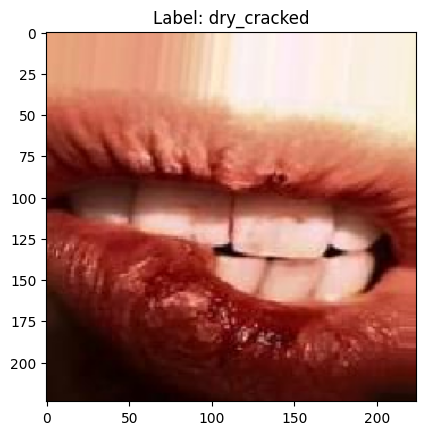

In [5]:
# Preprocess images
def preprocess_images(image_paths, labels, img_size=(224, 224)):
    images = []
    for img_path in image_paths:
        try:
            if not os.path.exists(img_path):
                print(f"Warning: Image path does not exist: {img_path}")
                continue

            img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
            img = tf.keras.preprocessing.image.img_to_array(img)

            if np.all(img == 0):
                print(f"Warning: Image {img_path} is filled with zeros after conversion.")
                continue
            
            images.append(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    
    images = np.array(images) / 255.0  # Normalize
    labels = np.array(labels)
    return images, labels

# Define class names
class_names = ["dry_cracked", "inflammed", "pale"]

# Directories for images and annotations
image_dir = "C:/Users/kaush/Downloads/LIPS_IMPLRMENTATION/lips dataset/augmented_train"
xml_dir = "C:/Users/kaush/Downloads/LIPS_IMPLRMENTATION/annotation"

# Load and preprocess the data
image_paths, labels = load_data(image_dir, xml_dir, class_names)
print(f"Number of images: {len(image_paths)}")
print(f"Number of labels: {len(labels)}")
images, labels = preprocess_images(image_paths, labels)

# Display a sample image
if len(images) > 0:
    plt.imshow(images[0])
    plt.title(f"Label: {class_names[labels[0]]}")
    plt.show()
else:
    print("No images were loaded. Please check the image paths and data.")


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.3582 - loss: 1.8636
Epoch 1: val_loss improved from inf to 2.23938, saving model to best_mobilenet_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 860ms/step - accuracy: 0.3586 - loss: 1.8540 - val_accuracy: 0.0444 - val_loss: 2.2394
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.4482 - loss: 1.4252
Epoch 2: val_loss improved from 2.23938 to 1.82761, saving model to best_mobilenet_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 791ms/step - accuracy: 0.4467 - loss: 1.4271 - val_accuracy: 0.1000 - val_loss: 1.8276
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.4585 - loss: 1.2300
Epoch 3: val_loss improved from 1.82761 to 1.42935, saving model to best_mobilenet_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 702ms/step - accuracy: 0.4576 - loss: 1.2312 - val_accuracy: 0.3000 - val_loss: 1.4293
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.5101 - loss: 1.0765
Epoch 4: val_loss did

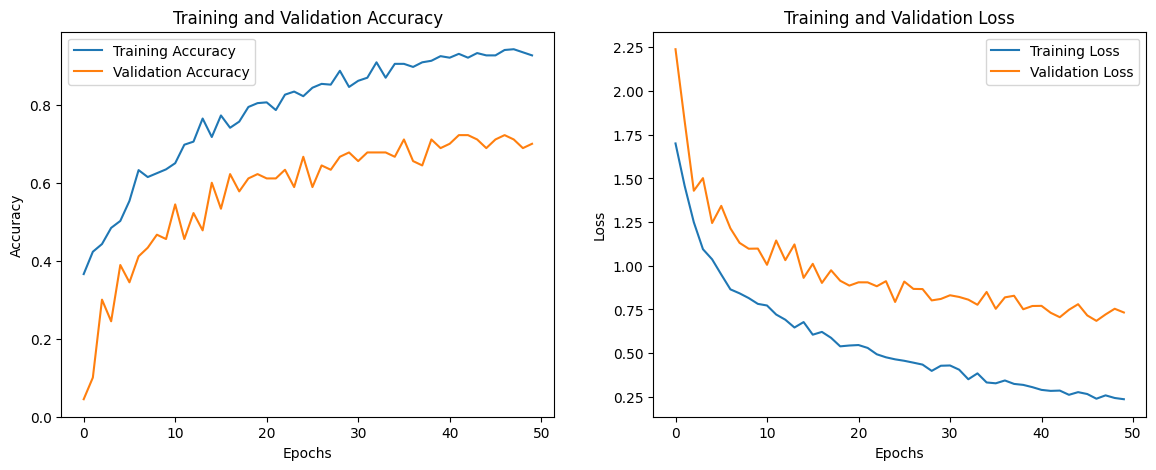

19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 617ms/step
              precision    recall  f1-score   support

 dry_cracked       0.93      1.00      0.97       198
   inflammed       0.93      0.98      0.96       198
        pale       0.98      0.86      0.92       200

    accuracy                           0.95       596
   macro avg       0.95      0.95      0.95       596
weighted avg       0.95      0.95      0.95       596



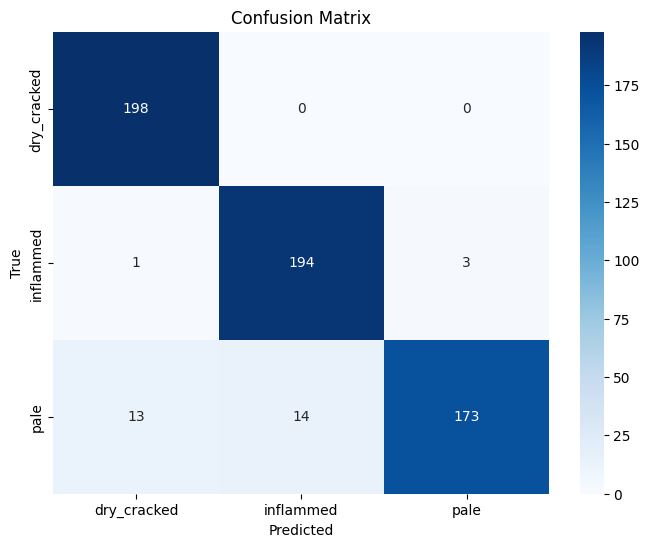

In [6]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pickle
import tensorflow as tf

# Load MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers using GlobalAveragePooling2D
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Use GAP instead of Flatten
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(class_names), activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set up model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_mobilenet_model.keras', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# Train the model with checkpoint callback
history = model.fit(images, labels, epochs=50, validation_split=0.15, 
                    batch_size=32, callbacks=[checkpoint])

# Save the training history using pickle
with open('training_history_mobilenet.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Plot accuracy and loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Load the best model (after training)
best_model = tf.keras.models.load_model('best_mobilenet_model.keras')

# Evaluate the best model
preds = np.argmax(best_model.predict(images), axis=1)

# Confusion matrix and classification report
cm = confusion_matrix(labels, preds)
print(classification_report(labels, preds, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
